<a href="https://colab.research.google.com/github/sankalpachowdhury/Galaxy-Classification-using-CNN/blob/master/Decisiontree_to_3classes_sankalpa_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras 
from keras.models import Sequential
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
%matplotlib inline
import os, random, shutil

from keras_preprocessing import image


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#!unzip "/content/drive/My Drive/Astronomical /Test.zip"

In [ ]:
!unzip "/content/drive/My Drive/Astronomical /Train.zip"

In [5]:
df = pd.read_csv('/content/drive/My Drive/Astronomical /Train.csv')
#df_t = pd.read_csv('/content/drive/My Drive/Astronomical /Test.csv')

print(df.head)

<bound method NDFrame.head of        GalaxyID  Class1.1  Class1.2  ...  Class11.4  Class11.5  Class11.6
0        100008  0.383147  0.616853  ...   0.000000   0.000000   0.325512
1        100023  0.327001  0.663777  ...   0.000000   0.000000   0.000000
2        100053  0.765717  0.177352  ...   0.000000   0.000000   0.000000
3        100078  0.693377  0.238564  ...   0.000000   0.000000   0.000000
4        100090  0.933839  0.000000  ...   0.000000   0.000000   0.000000
...         ...       ...       ...  ...        ...        ...        ...
9996     248461  0.083000  0.889000  ...   0.222252   0.305812   0.305812
9997     248466  0.439049  0.527396  ...   0.000000   0.000000   0.298742
9998     248470  0.256421  0.737000  ...   0.000000   0.000000   0.139880
9999     248471  0.796456  0.203544  ...   0.000000   0.000000   0.000000
10000    248516  0.940208  0.041105  ...   0.000000   0.000000   0.000000

[10001 rows x 38 columns]>


In [9]:
cols = df.columns
new = list(map(lambda s: s.replace('Class','Q'), cols))
df.columns = new

In [10]:
df.shape

(10001, 38)

In [11]:
df.head(5)

,GalaxyID,Q1.1,Q1.2,Q1.3,Q2.1,Q2.2,Q3.1,Q3.2,Q4.1,Q4.2,Q5.1,Q5.2,Q5.3,Q5.4,Q6.1,Q6.2,Q7.1,Q7.2,Q7.3,Q8.1,Q8.2,Q8.3,Q8.4,Q8.5,Q8.6,Q8.7,Q9.1,Q9.2,Q9.3,Q10.1,Q10.2,Q10.3,Q11.1,Q11.2,Q11.3,Q11.4,Q11.5,Q11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027226,0.000000,0.027226,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [12]:
ellipticals = df[(df['Q1.1']>0.8) & (df['Q7.1']>0.4)]['GalaxyID'].tolist()
#ellipticals

In [13]:

lenticulars = df[(df['Q1.1']>0.8) & (df['Q7.2']>0.4)]['GalaxyID'].tolist()
#lenticulars

In [14]:
spirals = df[(df['Q1.2']>0.8) & (df['Q2.1']>0.4)]['GalaxyID'].tolist()
#spirals

In [15]:
print('Total number of elliptical examples: ',  len(ellipticals))
print('Total number of lenticular examples: ',  len(lenticulars))
print('Total number of spiral examples: ',  len(spirals))

Total number of elliptical examples:  723
Total number of lenticular examples:  600
Total number of spiral examples:  478


In [16]:
source_path = '/content/Train'
dest_path = '/content/data'

In [17]:
def _proc_images(src, dst, label, arr, percent):
    train_dir = os.path.join(dst, 'train')
    val_dir = os.path.join(dst, 'validation')
    
    train_dest = os.path.join(train_dir, label)
    val_dest   = os.path.join(val_dir, label)
    
    if not os.path.exists(train_dest):
        os.makedirs(train_dest)

    if not os.path.exists(val_dest):
        os.makedirs(val_dest)
    
    random.shuffle(arr)
    
    idx = int(len(arr)*percent)
    for i in arr[0:idx]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(train_dest, str(i)+'.jpg'))
    for i in arr[idx:]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(val_dest, str(i)+'.jpg'))
    
    print(label, 'done!')


In [18]:

_proc_images(source_path, dest_path, 'elliptical', ellipticals, 0.9)
_proc_images(source_path, dest_path, 'lenticular', lenticulars, 0.9)
_proc_images(source_path, dest_path, 'spiral', spirals, 0.9)

elliptical done!
lenticular done!
spiral done!


Data Processing

In [19]:
import os
import PIL
import PIL.Image

In [ ]:
'''
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.transform import resize

ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

def get_image(path, x1,y1, shape, crop_size):
    x = plt.imread(path)
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    # x = resize(x, shape)
    x = x/255.
    return x

def get_all_images(path,df,shape=IMG_SHAPE, crop_size=CROP_SIZE, orig_size = ORIG_SHAPE, r=600):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
   
    sel = df.values
    ids = sel[:r,0].astype(int).astype(str)
    y_batch = sel[:r,1:]
    x_batch = []
    for i in tqdm(ids):
      
      x = get_image(path+i+'.jpg', x1,y1, shape=shape, crop_size=crop_size)
      x_batch.append(x)
    print(i)
    x_batch = np.array(x_batch)
    return x_batch, y_batch
            
x_train, y_train = get_all_images('/content/Train/',df)
x_test, y_test = get_all_images('/content/Test/',df_t)
print(x_train.shape)
print(y_train.shape)
print(type(y_train))
print(x_test.shape)
print(y_test.shape)
print(type(y_test))
'''

In [20]:
train_dir = 'data/train'
validation_dir = 'data/validation'
# make a directory in colabs "data" and copy the path.

In [21]:

total_train = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_train += len(os.listdir(os.path.join(train_dir, c)))
print('Total train:', total_train)

total_validation = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_validation += len(os.listdir(os.path.join(validation_dir, c)))
print('Total validation:', total_validation)

Total train: 1620
Total validation: 181


In [22]:
# parameters
target = (256, 256)
batch_size = 64

In [23]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=25,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.2)
validation_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical')
validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                         target_size=target,
                                                         batch_size=batch_size,
                                                         shuffle=False,
                                                         class_mode='categorical')

Found 1620 images belonging to 3 classes.
Found 181 images belonging to 3 classes.


In [24]:
r_coeff = 0.001

In [25]:
from keras import regularizers


model = keras.models.Sequential([keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)),
                                keras.layers.Conv2D(64,(3,3),activation='relu', kernel_regularizer = regularizers.l2(r_coeff)),
                                keras.layers.MaxPooling2D((20,20),strides=(2,2)),
                                keras.layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer = regularizers.l2(r_coeff)),
                                keras.layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer = regularizers.l2(r_coeff)),
                                keras.layers.MaxPooling2D((2,2)),# Deafault takes stride = (2,2)
                                keras.layers.Flatten(),
                                keras.layers.Dense(512,activation='relu',kernel_regularizer = regularizers.l2(r_coeff)),
                                keras.layers.Dense(512,activation='relu',kernel_regularizer = regularizers.l2(r_coeff)),
                                keras.layers.Dense(3,activation = 'softmax',kernel_regularizer = regularizers.l2(r_coeff))
                                ])
#model1.add()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 117, 117, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 115, 115, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 113, 113, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 401408)           

In [26]:
from tensorflow.keras.optimizers import Adam 

model.compile(optimizer=Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

In [28]:
EPOCHS = 100



In [30]:
history = model.fit_generator(train_generator,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    verbose=1)

Epoch 1/100
26/26 [==============================] - 48s 2s/step - loss: 1.4626 - acc: 0.3944 - val_loss: 1.4998 - val_acc: 0.3978
Epoch 2/100
26/26 [==============================] - 45s 2s/step - loss: 1.2999 - acc: 0.4716 - val_loss: 1.4347 - val_acc: 0.5193
Epoch 3/100
26/26 [==============================] - 46s 2s/step - loss: 1.2604 - acc: 0.4988 - val_loss: 1.3392 - val_acc: 0.5525
Epoch 4/100
26/26 [==============================] - 46s 2s/step - loss: 1.1664 - acc: 0.5457 - val_loss: 1.3359 - val_acc: 0.5801
Epoch 5/100
26/26 [==============================] - 45s 2s/step - loss: 1.0743 - acc: 0.5938 - val_loss: 1.1742 - val_acc: 0.5856
Epoch 6/100
26/26 [==============================] - 46s 2s/step - loss: 0.9961 - acc: 0.5778 - val_loss: 0.7744 - val_acc: 0.6133
Epoch 7/100
26/26 [==============================] - 46s 2s/step - loss: 0.9498 - acc: 0.5889 - val_loss: 0.6596 - val_acc: 0.5912
Epoch 8/100
26/26 [==============================] - 46s 2s/step - loss: 0.9074 - a

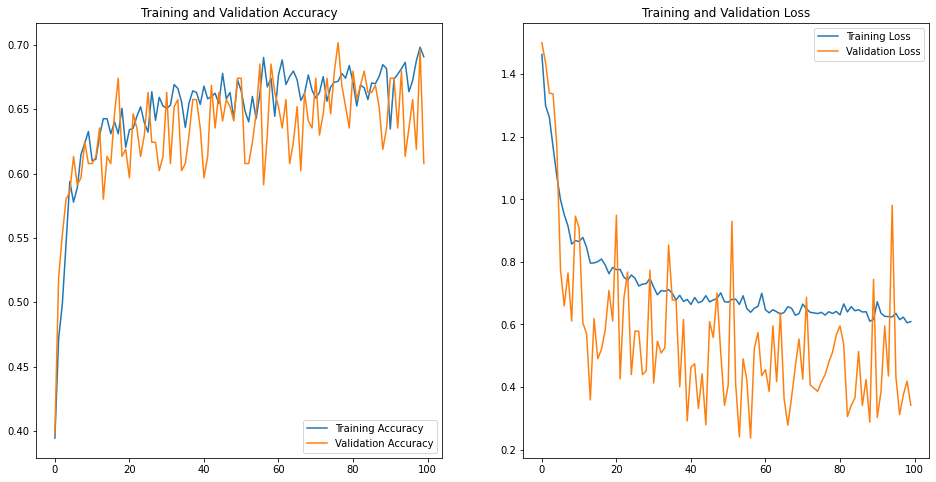

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # range for the number of epochs

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./plots-v2.png')
plt.show()

In [ ]:
'''
model.fit(x_train, y_train, batch_size = 64, epochs= EPOCHS, validation_data=(x_test, y_test))


history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    verbose=1)
'''

In [ ]:
model.save('galaxy-convnet-v2.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
